# DATING APP REVIEW ANALYSIS
---

**Author:** Tyler Chang • **Data Source:** [Link]('https://www.kaggle.com/datasets/sidharthkriplani/datingappreviews') • **Current Version:** 1.0 • **Latest Update:** July 29, 2023

---

This report covers the analysis of over 650,000 reviews for Tinder, Bumble, and Hinge between 2017--2022. 

This is a in-progress project and will be updated regularly until completion (current ETA: August 1st, 2023).

#### Versions

* **1.0:** Data cleaning, basic statistical analysis, data visualizations
* **1.1:** [In-Progress] Text additions and base model for predicting numeric ratings

---

### LOADING ALL REQUIRED PACKAGES AND LIBRARIES

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import string
from datetime import datetime
import re

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from textblob import Word, TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# miscellaneous
import time
import pickle

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import ensemble, naive_bayes
from sklearn.metrics import f1_score, accuracy_score

Due to the size of the raw data file, it has been downloaded and loaded locally. 

In [2]:
### Loading the dataset
df = pd.read_csv('DatingAppReviewsDataset.csv')

## DATA CLEANING

In [3]:
### Looking at the first 5 rows of the raw table
df.head(5)

,Unnamed: 0,Name,Review,Rating,#ThumbsUp,Date&Time,App
0,0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder
1,1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder
2,2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder
3,3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder
4,4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder


The first two columns--*Unnamed:0* and *Name*--are unneeded and can be removed.

In [4]:
df.drop(columns = ['Unnamed: 0', 'Name'], inplace = True)

In [5]:
### dimensions of the table
df.shape

(681994, 5)

There are 681,994 rows of data and 5 columns. The columns are as follows:

* *Review*: Text reviews that accompanied a user's numeric rating of the app.
* *Rating*: Numeric score a user gave the app during the review process.
* *#ThumbsUp*: Number of other users who marked a review as helpful.
* *Date&Time*: Records the day, month, year, and time of the review being submitted.
* *App*: Indicates which app is being reviewed.

In [6]:
### overview of the current table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681994 entries, 0 to 681993
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     680609 non-null  object
 1   Rating     681994 non-null  int64 
 2   #ThumbsUp  681994 non-null  int64 
 3   Date&Time  681994 non-null  object
 4   App        681994 non-null  object
dtypes: int64(2), object(3)
memory usage: 26.0+ MB


The Review column is the only one missing values. 

In [7]:
### number of missing values in the review column
df.Review.isna().sum()

1385

Since there are only 1,352 missing reviews (roughly 0.1% of the overall data), I am going to drop them. While the numeric scores are available, the minimal percentage of the data being lost is unlikely to make a nontrivial impact on the overall analysis.

In [8]:
### dropping the rows with no text review
df.drop(df[df.Review.isna()].index, inplace = True)

We can now start cleaning up the review texts. To do this, I have built a function that makes all sentences lowercase, removes all numbers and punctuation, and strips off the excess whitespace.

In [9]:
### base text cleaning function
def bas_txt_clean(sentence):
    # Making the entire sentence lowercase
    sentence = sentence.lower()
    # Removing the numbers 
    sentence = ''.join(char for char in sentence if not char.isdigit())
    # Removing punctuation
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')
    # Removing whitespace
    sentence = sentence.strip()
    # Returning the cleaned text
    return sentence

### applying the function to the reviews and adding a new column
df['cleaned_reviews'] = [bas_txt_clean(sentence) for sentence in df['Review']]

### dropping the original review column
df.drop(columns = 'Review', inplace = True)

The Date&Time column is currently a string and needs to be converted to a date-time format.

In [10]:
### converting the Date&Time column to correct format and adding to table as new column
df['Time'] = [datetime.strptime(dt, "%d-%m-%Y %H:%M") for dt in df['Date&Time']]

### removing the original Date&Time column
df.drop(columns='Date&Time', inplace=True)

Since the review scores are supposed to be between 1 and 5 (inclusive), I will check that all ratings are within that range.

In [11]:
df.Rating.value_counts()

Rating
1    251842
5    232732
4     86958
3     56850
2     52226
0         1
Name: count, dtype: int64

There is a single review that has a rating of 0, which can now be dropped.

In [12]:
df.drop(df[df.Rating == 0].index, inplace = True)

Finally, instead of just using numeric representations for the rating, I will create a new column that includes sentiment vocabulary.

In [13]:
# making a list of the sentiment labels
sent_label = []
for rev in df.Rating:
    if rev == 1:
        sent_label.append('Terrible')
    elif rev == 2:
        sent_label.append('Bad')
    elif rev == 3:
        sent_label.append('Neutral')
    elif rev == 4:
        sent_label.append('Good')
    else:
        sent_label.append('Excellent')

### adding the list to the table as a new column
df['Sentiment_Category'] = sent_label

## Statistical Analysis and Data Visualization

In [14]:
### number of reviews per app
pd.DataFrame(df.groupby('App')['Rating'].describe())[['count', 'mean', 'std']]

,count,mean,std
App,,,
Bumble,102376.0,2.832265,1.716081
Hinge,52990.0,3.180921,1.680777
Tinder,525242.0,3.007800,1.757112


Tinder, as the oldest app with the largest user-base, has the most reviews and accounts for approximately 77% of the data. Reviews of Bumble and Hinge make up approximately 15% and 8% of the data, respectively. 

All three apps have average ratings around 3, with Bumble falling slightly below at 2.83 and Hinge coming in slightly above at 3.18. The high standard deviations suggest that the majority of users do not actual give a rating of 3; most users seem to either rate quite high or quite low. This is supported by the following graph.

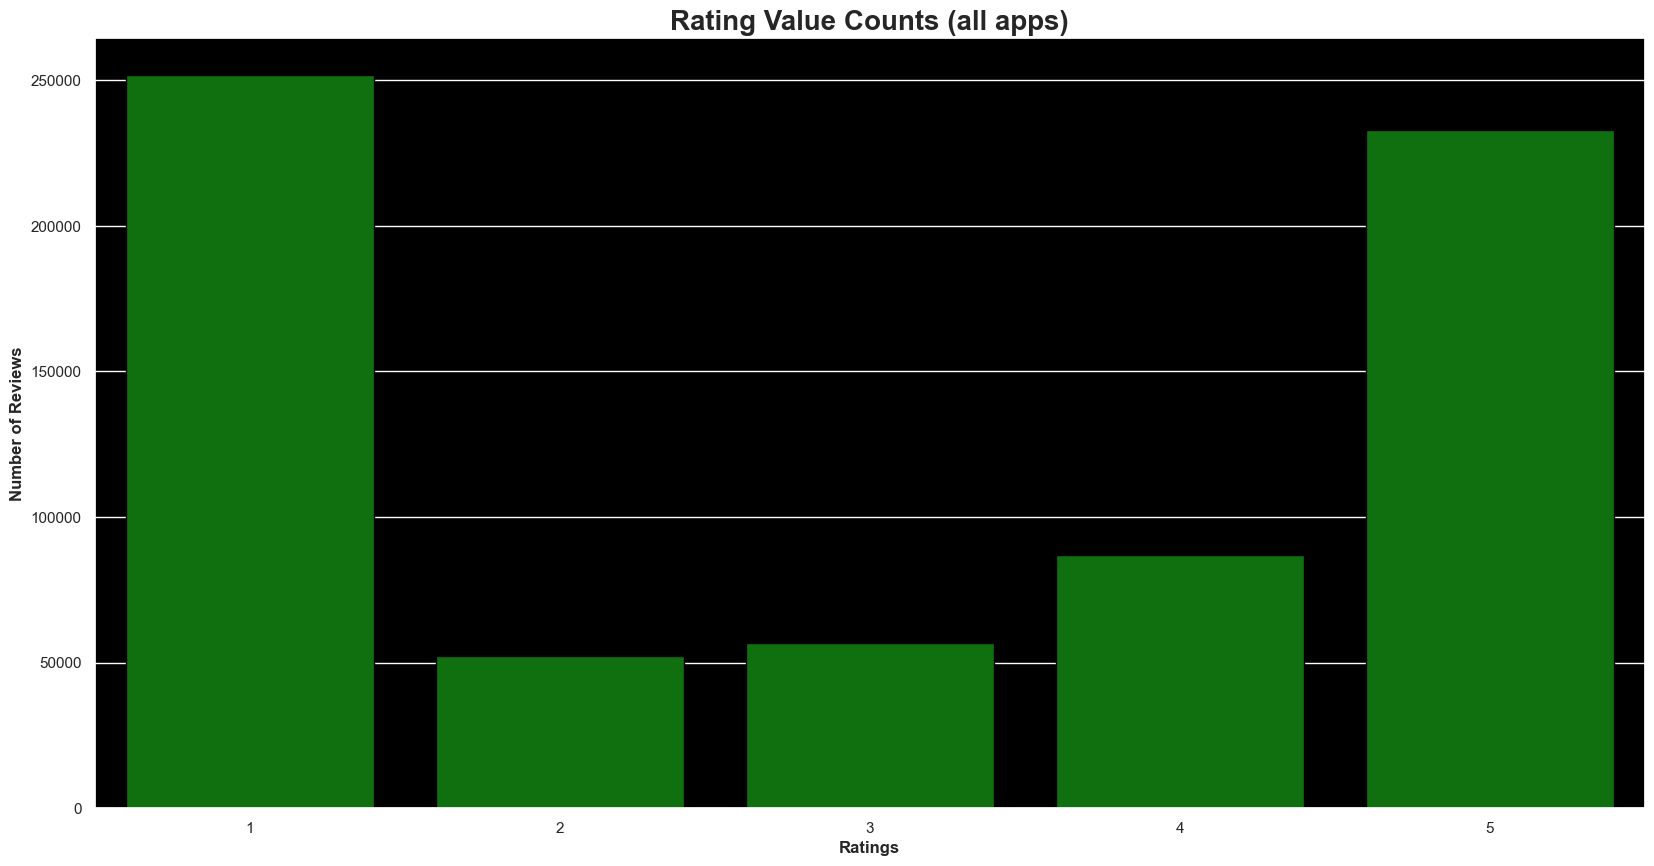

In [18]:
### BAR CHART OF THE RATINGS

# Making a new dataframe with sorted totals of each review
tmp = pd.DataFrame(df.groupby('Rating').count()['Sentiment_Category']).reset_index().sort_values(by = 'Rating')

# Making a barplot
bar1 = sns.barplot(data = tmp, 
            x = 'Rating', 
            y = 'Sentiment_Category',
            color = 'green',
            edgecolor = 'black')
bar1.set_title('Rating Value Counts (all apps)', fontsize = 20, fontweight = 'bold')
bar1.set_xlabel('Ratings', fontsize = 12, fontweight = 'bold')
bar1.set_ylabel('Number of Reviews', fontsize = 12, fontweight = 'bold')
bar1.set_facecolor('black')

Approximately 71.2% of the ratings are either a 1 or 5. This suggests that those most inclined to write a review are either those who strongly like or strongly dislike the app. The same can be seen even when the ratings are limited to a single app.

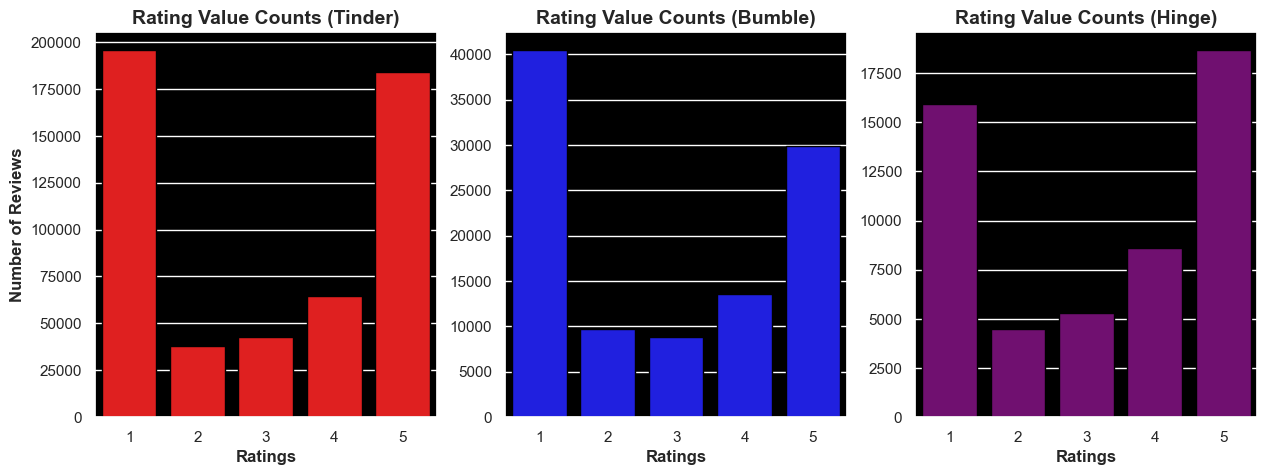

In [23]:
### setting up the format of the plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

### TINDER PLOT
tmp = pd.DataFrame(df[df.App == 'Tinder'].groupby('Rating').count()['Sentiment_Category']).reset_index().sort_values(by = 'Rating')
bar2 = sns.barplot(data = tmp, 
            x = 'Rating', 
            y = 'Sentiment_Category',
            color = 'red',
            edgecolor = 'black',
            ax = axes[0])
axes[0].set_title('Rating Value Counts (Tinder)', fontsize = 14, fontweight = 'bold')
axes[0].set_xlabel('Ratings', fontsize = 12, fontweight = 'bold')
axes[0].set_ylabel('Number of Reviews', fontsize = 12, fontweight = 'bold')
axes[0].set_facecolor('black')

### BUMBLE PLOT
tmp = pd.DataFrame(df[df.App == 'Bumble'].groupby('Rating').count()['Sentiment_Category']).reset_index().sort_values(by = 'Rating')
bar3 = sns.barplot(data = tmp, 
            x = 'Rating', 
            y = 'Sentiment_Category',
            color = 'blue',
            edgecolor = 'black',
            ax = axes[1])
axes[1].set_title('Rating Value Counts (Bumble)', fontsize = 14, fontweight = 'bold')
axes[1].set_xlabel('Ratings', fontsize = 12, fontweight = 'bold')
axes[1].set_ylabel('')
axes[1].set_facecolor('black')

### HINGE PLOT
tmp = pd.DataFrame(df[df.App == 'Hinge'].groupby('Rating').count()['Sentiment_Category']).reset_index().sort_values(by = 'Rating')
sns.barplot(data = tmp, 
            x = 'Rating', 
            y = 'Sentiment_Category',
            color = 'purple',
            edgecolor = 'black',
            ax = axes[2])
axes[2].set_title('Rating Value Counts (Hinge)', fontsize = 14, fontweight = 'bold')
axes[2].set_xlabel('Ratings', fontsize = 12, fontweight = 'bold')
axes[2].set_ylabel('')
axes[2].set_facecolor('black')

Interestingly, Hinge is the only app where the largest rating category is 5. That said, it is also the neweset of the apps and has the fewest number of reviews. To gain better perspective on how the apps have been viewed, let's look at the ratings per app over time.

<function matplotlib.pyplot.show(close=None, block=None)>

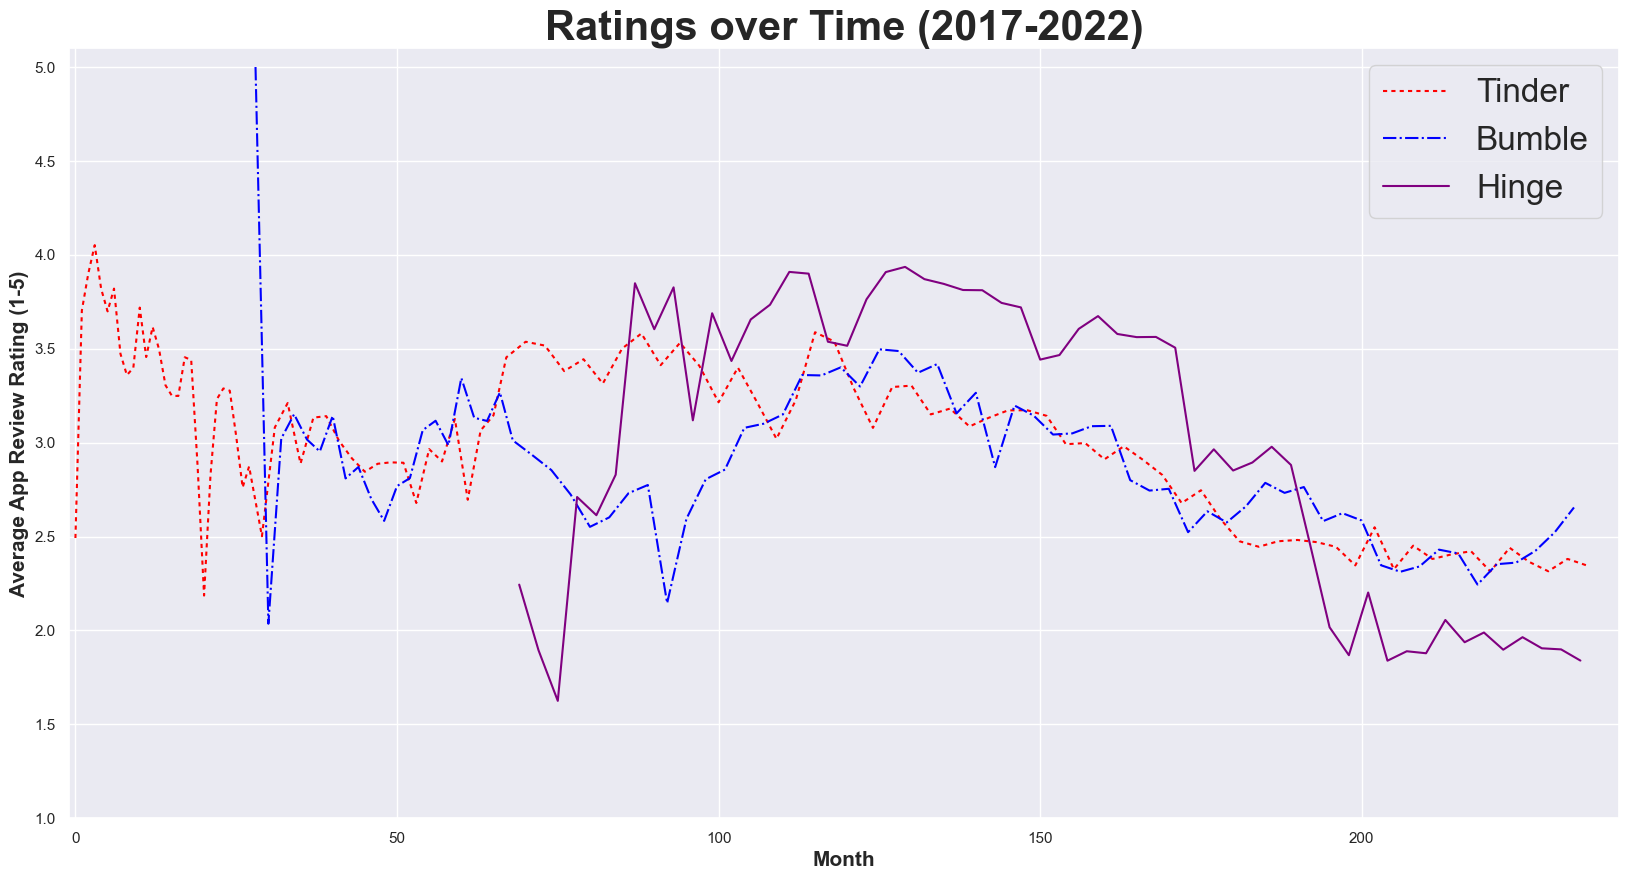

In [22]:
### AVERAGE RATING BY APP BY MONTH
df['year'] = df.Time.dt.year
df['month'] = df.Time.dt.month

# average rating by month
avg_rat_per_month = df.groupby(['year', 'month', 'App'])['Rating'].mean().reset_index(name = 'avg')

# Getting the three dataframe (one per app)
hinge_rating_avg_df = avg_rat_per_month[avg_rat_per_month.App == 'Hinge'].reset_index()
bumble_rating_avg_df = avg_rat_per_month[avg_rat_per_month.App == 'Bumble'].reset_index()
tinder_rating_avg_df = avg_rat_per_month[avg_rat_per_month.App == 'Tinder'].reset_index()

### PLOTTING THE RATING AVERAGES OVER TIME
sns.set_style("dark")
sns.set(rc = {'figure.figsize': (20, 10)})

fig, ax = plt.subplots()

# tinder plot
sns.lineplot(data = tinder_rating_avg_df, x = 'index', y = 'avg', 
            linestyle=(0, (2, 2)), ax = ax, label = 'Tinder',
            color = 'red')
# bumble plot
sns.lineplot(data = bumble_rating_avg_df, x = 'index', y = 'avg', 
             linestyle = '-.', ax = ax, label = 'Bumble',
             color = 'blue')
# hinge plot
sns.lineplot(data = hinge_rating_avg_df, x = 'index', y = 'avg', 
             linestyle = '-', ax = ax, label = 'Hinge', 
             color = 'purple')

# changing the x-axis 
plt.xlabel('Month', fontsize = 15, fontweight = 'bold')
plt.xlim((-1,240))

# changing the y-axis
plt.ylabel('Average App Review Rating (1-5)', fontsize = 15, fontweight = 'bold')
plt.ylim((1,5.1))

# changing the size of the legend
plt.legend(prop = {'size': 24})

# adding a title
plt.title('Ratings over Time (2017-2022)', fontsize = 30, fontweight = 'bold')

# showing the plot
plt.show

All three apps have seen a decrease in popularity over time, with Hinge receiving the largest drop over the past few years. Notably, the consistent decline in ratings for all three accelerated approximately 3 years ago, roughly corresponding with the start of the Covid-19 pandemic. Whether the generally raised levels of stress and isolation reported by many during the pandemic had on the rating had a more negative affect on the reviews of these apps over other apps cannot be determined from this data but is worth investigating. 

To gain better insight into the sorts of comments associated with each numeric rating, we can start by look at the most commonly appearing words across all reviews.

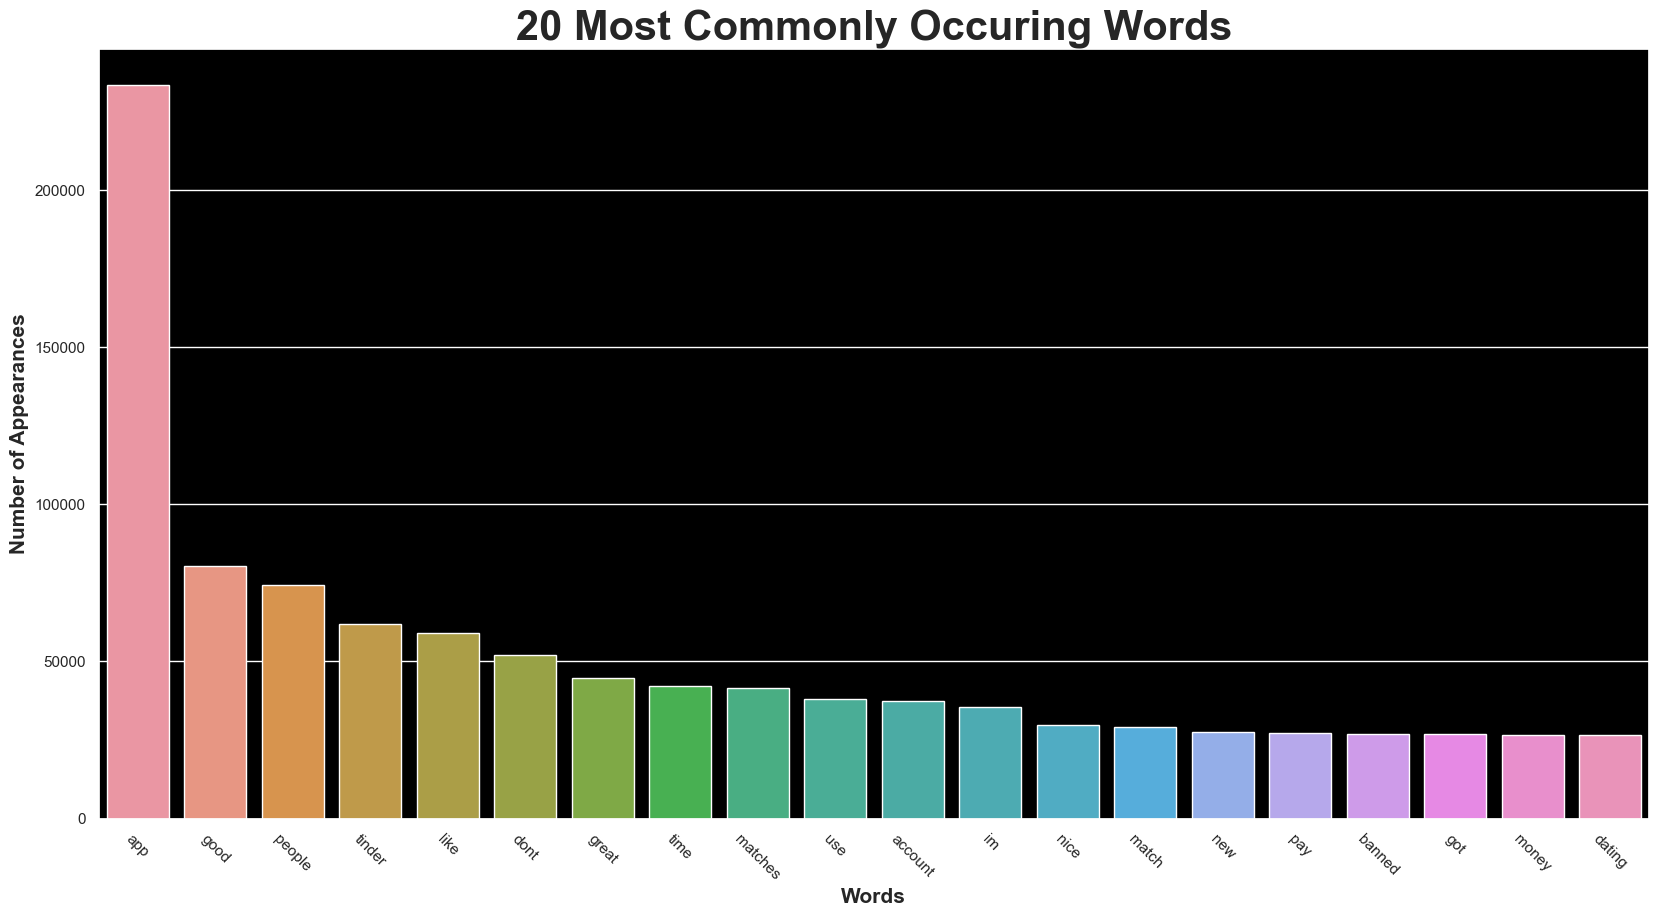

In [18]:
### Determining the most commonly appearing words

# removing the stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)
df['reviews_no_stopwords'] = df['cleaned_reviews'].apply(remove_stopwords)

# vectorizing the words
c = CountVectorizer(stop_words = 'english')
word = c.fit_transform(df.reviews_no_stopwords)
word_sum = word.sum(axis = 0)

# determining the actual frequencies
word_freq = [(word, word_sum[0,i]) for word, i in c.vocabulary_.items()]
word_freq = sorted(word_freq, key = lambda x:x[1], reverse = True)
word_freq_df = pd.DataFrame(word_freq, columns = ['Word', 'Frequency'])

# drawing the barplot
bar2 = sns.barplot(data = word_freq_df.head(20), x = 'Word', y = 'Frequency');
sns.set(rc = {'figure.figsize': (20, 10)});
plt.xticks(rotation = 315);
bar2.set_title('20 Most Commonly Occuring Words', fontsize = 30, fontweight = 'bold')
bar2.set_ylabel('Number of Appearances', fontsize = 15, fontweight = 'bold')
bar2.set_xlabel('Words', fontsize = 15, fontweight = 'bold')
bar2.set_facecolor('black')
plt.show()

To gain a more comprehensive understanding of what the reviews consist of, we can also look at a word cloud of all the reviews.

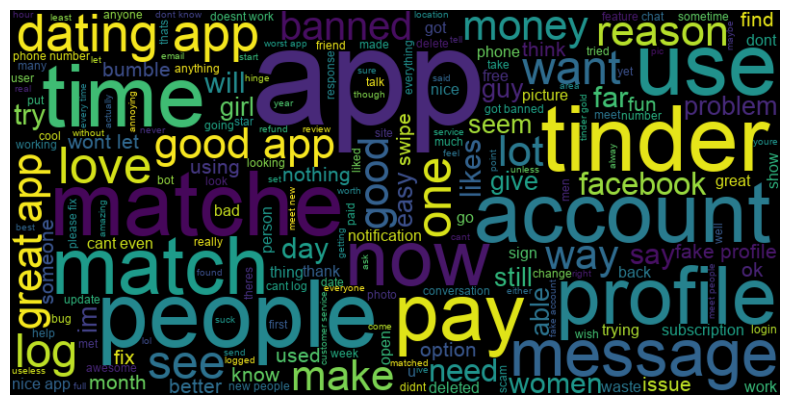

In [19]:
### word cloud (all apps)
txt = df.cleaned_reviews.str.cat(sep = ' ')
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
wordcloud = WordCloud(font_path= font_path, width=800, height=400, background_color="black").generate(txt)
plt.figure(figsize=(40, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The most prominent words that express a sentiment or indicate the most commonly mentioned are:
* time
* good
* match
* now
* pay
* message

Though we cannot determine from this alone whether the sentiments associated with each comment were positive or negative, we can make some reasonable assumptions. Since all three apps offer paid options that allow users access to features that better personalize the user experience, such as allowing a person to see who has already expressed interest in their profile, it is not surprising that the word *pay* shows up frequently. Similarly, *time*, *match*, and *message* are all expected because of the selling point of dating apps is that one can theoretically save time looking for a romantic partner by having access to thousands of people's profiles on a phone. The idea is to match quickly and move onto messaging. This is not often the case, likely due in part to the disproportionate numbers of men and women typically using the app (the exact ratios have not been publicly disclosed but there seem to be far more men than women on Tinder, Bumble, and Hinge). That said, each of the apps have notably different marketing in regard to whom the app is intended to best serve.


Tinder is the most general, advertising itself as being open to all types of relationships. Bumble is unique among the three in that it requires that once two people's profiles match, the woman must be the one to initiate messaging and if no messages are exchanged within 24 hours (absent paid extensions), the match is dismissed. Hinge explicitly targets people looking for committed relationships, separating most notably from Tinder, which has a reputation for attracting people looking for shorter-term or one-off relationships. To see if these intended user-bases match up to the realities, let's look at word clouds for each app.

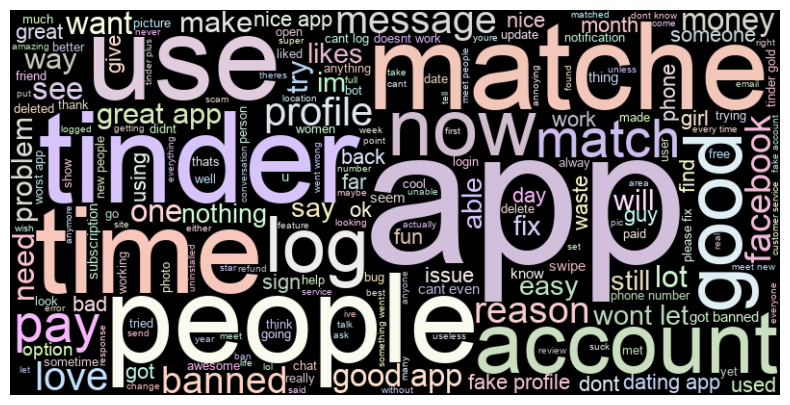

In [20]:
### tinder word cloud

### function to change color of words
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    r = int(np.random.randint(180, 256))
    g = int(np.random.randint(180, 256))
    b = int(np.random.randint(180, 256))
    return f"rgb({r}, {g}, {b})"

### making the word cloud
txt = df[df.App == "Tinder"].cleaned_reviews.str.cat(sep = ' ')
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
wordcloud = WordCloud(font_path= font_path, width=800, 
                      height=400, background_color="black",
                      color_func = custom_color_func).generate(txt)
plt.figure(figsize=(40, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looking only at the Tinder reviews, we again see words like *match*, *time*, *money*, and *pay*, with notable additions like *love* and *profile*. 

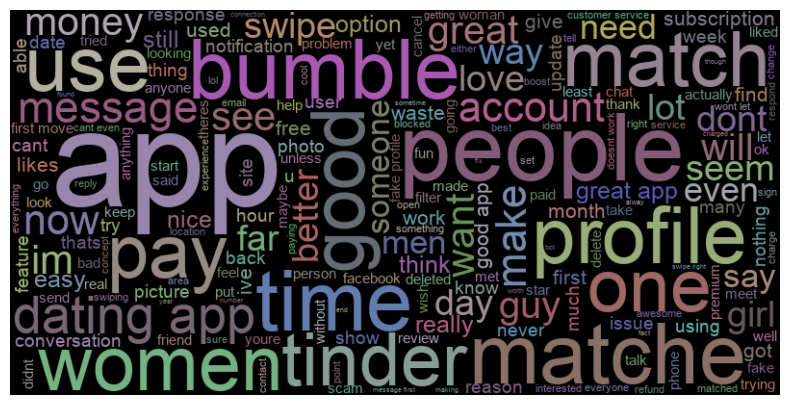

In [21]:
### Bumble word cloud
### function to change color of words
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    r = int(np.random.randint(90, 180))
    g = int(np.random.randint(90, 180))
    b = int(np.random.randint(90, 180))
    return f"rgb({r}, {g}, {b})"

### making the word cloud
txt = df[df.App == "Bumble"].cleaned_reviews.str.cat(sep = ' ')
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
wordcloud = WordCloud(font_path= font_path, width=800, 
                      height=400, background_color="black",
                      color_func = custom_color_func).generate(txt)
plt.figure(figsize=(40, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Interestingly, the word *tinder* appears in large number of reviews about Bumble. This is likely in the form of a comparison and is not surprising given that the two apps presently boast the largest active user bases. There are also more gender-specific words appearing here than with Tinder, which might be expected given Bumble's aforementioned policy about messaging.

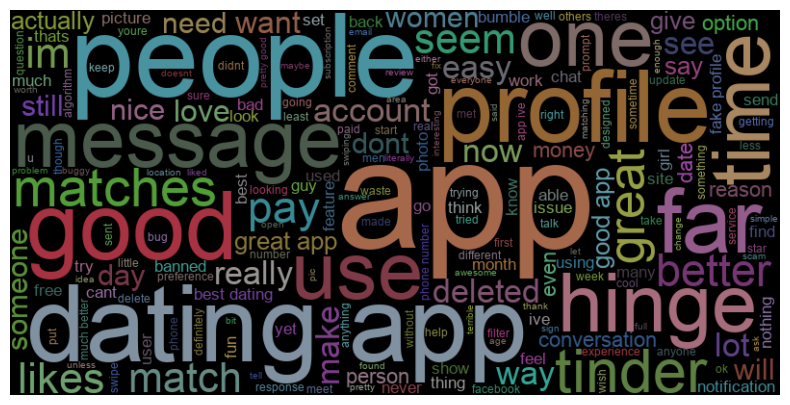

In [24]:
### Hinge word cloud
### function to change color of words
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    r = int(np.random.randint(50, 170))
    g = int(np.random.randint(50, 170))
    b = int(np.random.randint(50, 170))
    return f"rgb({r}, {g}, {b})"

### making the word cloud
txt = df[df.App == "Hinge"].cleaned_reviews.str.cat(sep = ' ')
font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
wordcloud = WordCloud(font_path= font_path, width=800, 
                      height=400, background_color="black",
                      color_func = custom_color_func).generate(txt)
plt.figure(figsize=(40, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Hinge seems to have, proportionally, the most positive words appearing in the reviews, with *good*, *better*, and *great* all appearing often. As with Bumble, *tinder* appears often, again suggesting comparisons being made in reviews. One particular word that stands out is *deleted*, which might refer to people deleting the app itself or, more positively, Hinge succeeding in their mission as stated by their slogan of "Designed to be Deleted".

## MACHINE LEARNING MODELS COMING SOON